In [1]:
import pandas as pd
import numpy as np

# Загрузка и просмотр данных
data = pd.read_csv('real_estate_data.csv')
print(data.head())
print(data.info())

      Neighborhood                     Type     Price  Beds  Baths  \
0   Inner Richmond  Single Family Residence    888000   3.0      1   
1     Outer Sunset  Single Family Residence    995000   2.0      1   
2  Pacific Heights  Single Family Residence  32000000   4.0     10   
3  Dolores Heights              Condominium   1095000   3.0      1   
4  Mission Dolores              Condominium    849000   3.0      2   

   Built Year   Longitude   Latitude  \
0      1911.0 -122.475296  37.779910   
1      1926.0 -122.493380  37.761646   
2      1987.0 -122.446290  37.793170   
3         NaN -122.428910  37.754200   
4      1890.0 -122.427880  37.763150   

                                                Link  
0  https://www.zillow.com/homedetails/427-16th-Av...  
1  https://www.zillow.com/homedetails/1367-34th-A...  
2  https://www.zillow.com/homedetails/2990-Broadw...  
3  https://www.zillow.com/homedetails/22-Vicksbur...  
4  https://www.zillow.com/homedetails/3670-17th-S...  
<class '

In [2]:
data.dropna(subset=['Beds', 'Baths', 'Built Year'], inplace=True)

data['Beds'] = data['Beds'].astype(int)
data['Baths'] = data['Baths'].astype(int)
data['Built Year'] = data['Built Year'].astype(int)

data.drop(columns=['Link'], inplace=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1242 entries, 0 to 1555
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  1242 non-null   object 
 1   Type          1242 non-null   object 
 2   Price         1242 non-null   int64  
 3   Beds          1242 non-null   int64  
 4   Baths         1242 non-null   int64  
 5   Built Year    1242 non-null   int64  
 6   Longitude     1242 non-null   float64
 7   Latitude      1242 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 87.3+ KB
None


In [3]:
# Обработка выбросов для признака Price
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['Price'] < (Q1 - 1.5 * IQR)) | (data['Price'] > (Q3 + 1.5 * IQR)))]

print(data.shape)

(1070, 8)


In [4]:
from sklearn.preprocessing import LabelEncoder

# Преобразование категориальных переменных
label_encoder = LabelEncoder()
data['Neighborhood'] = label_encoder.fit_transform(data['Neighborhood'])
data['Type'] = label_encoder.fit_transform(data['Type'])

# Проверка преобразованных данных
print(data[['Neighborhood', 'Type']].head())

   Neighborhood  Type
0            22     5
1            41     5
4            34     1
5            41     5
6             1     5


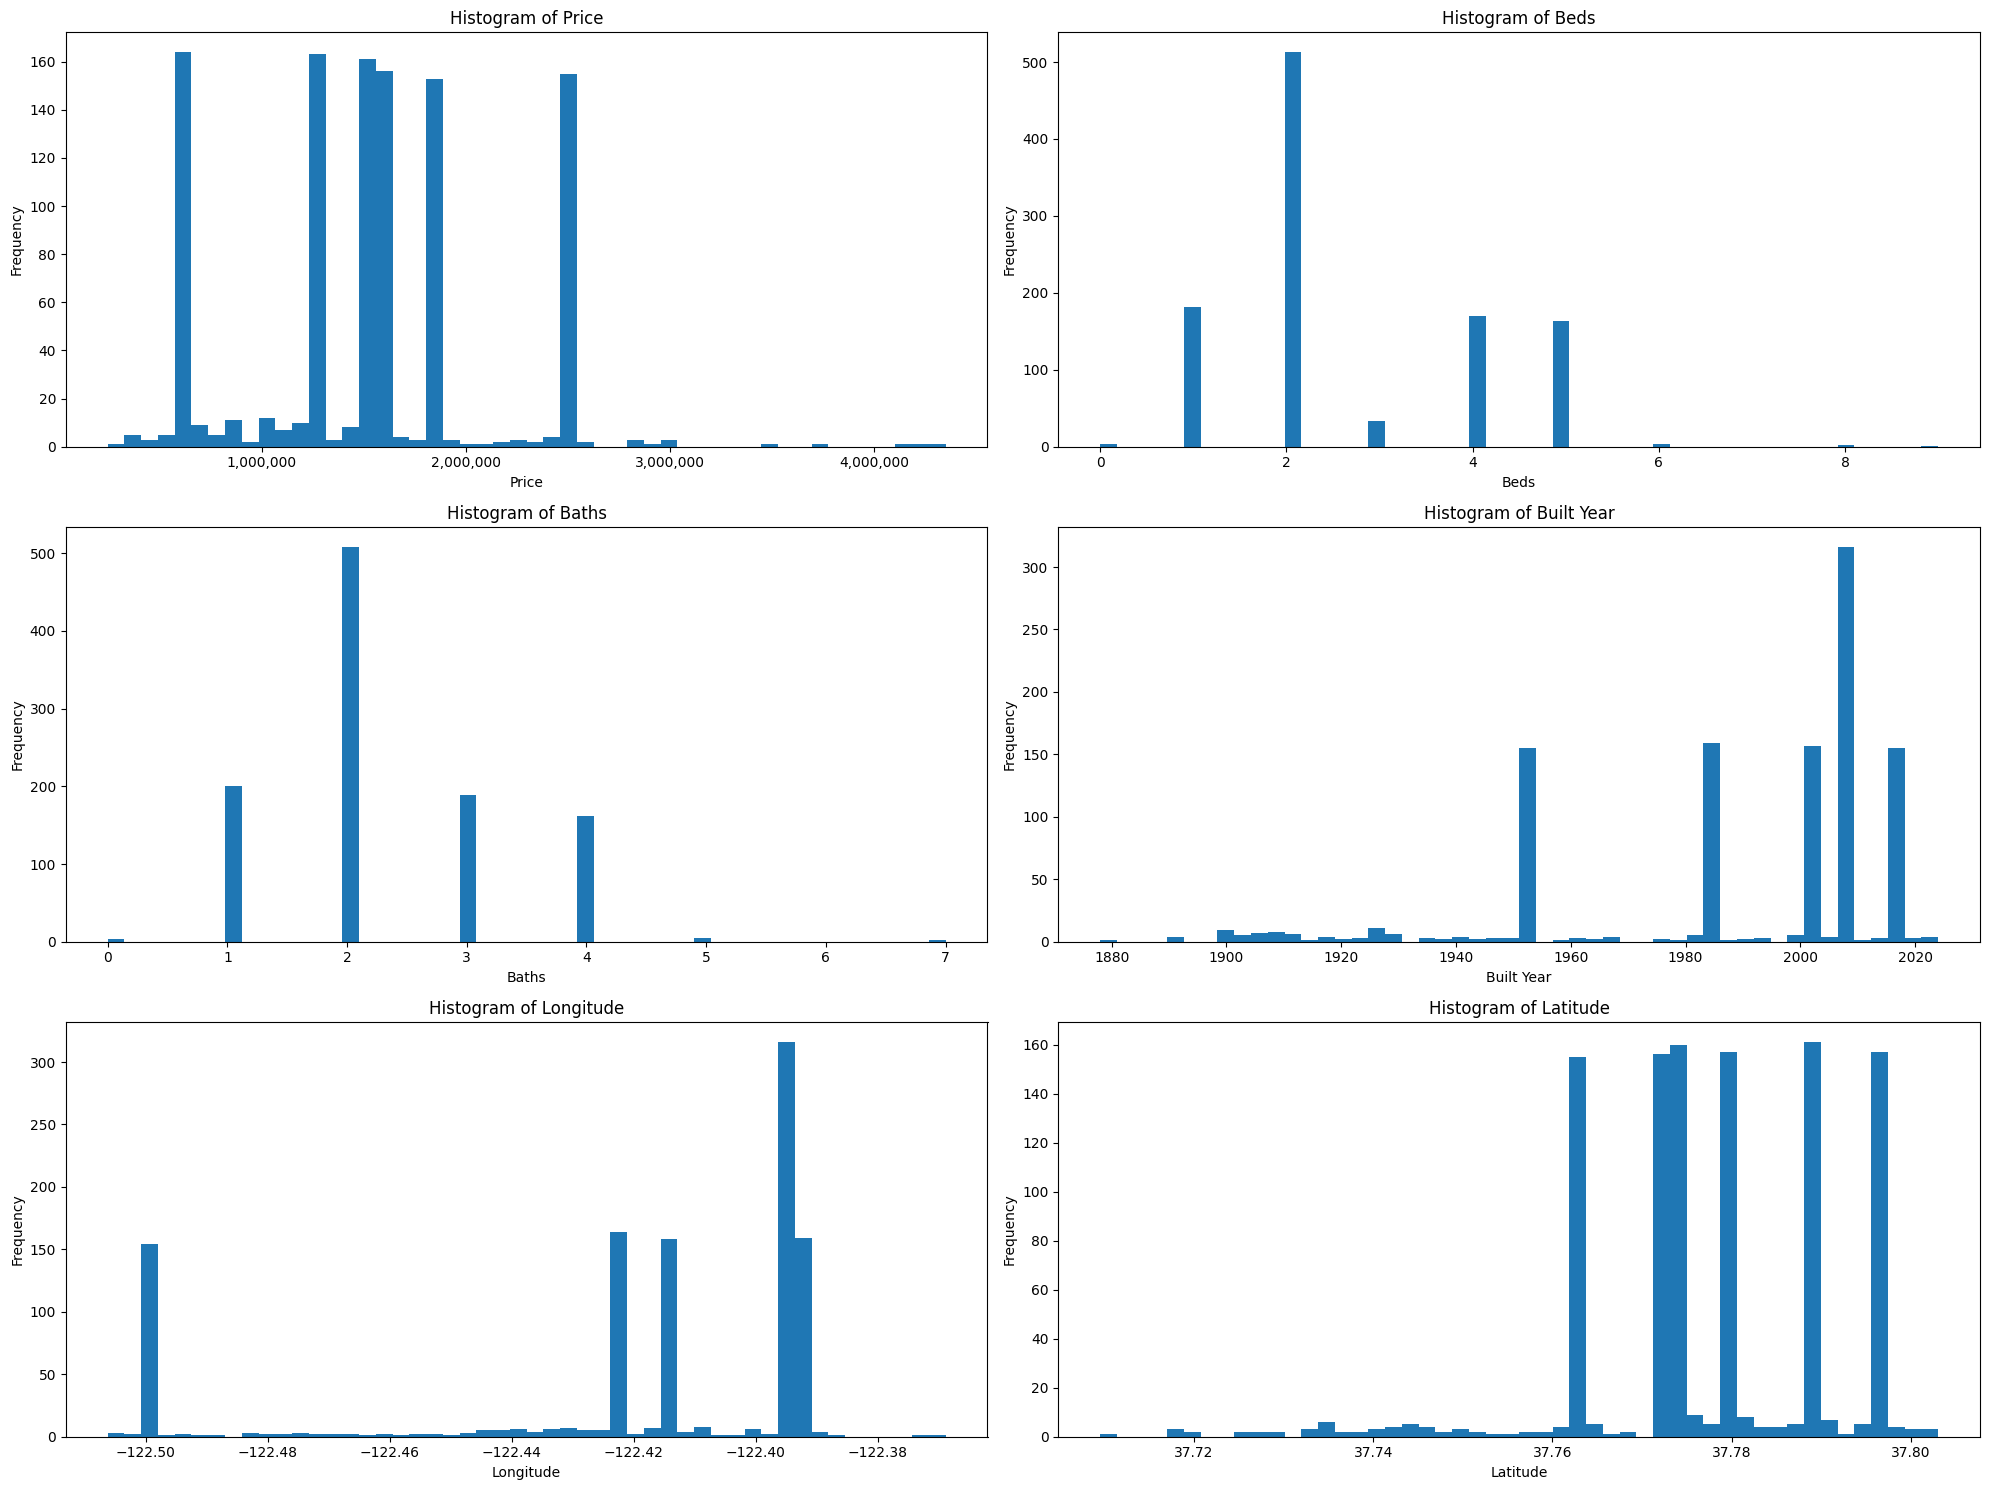

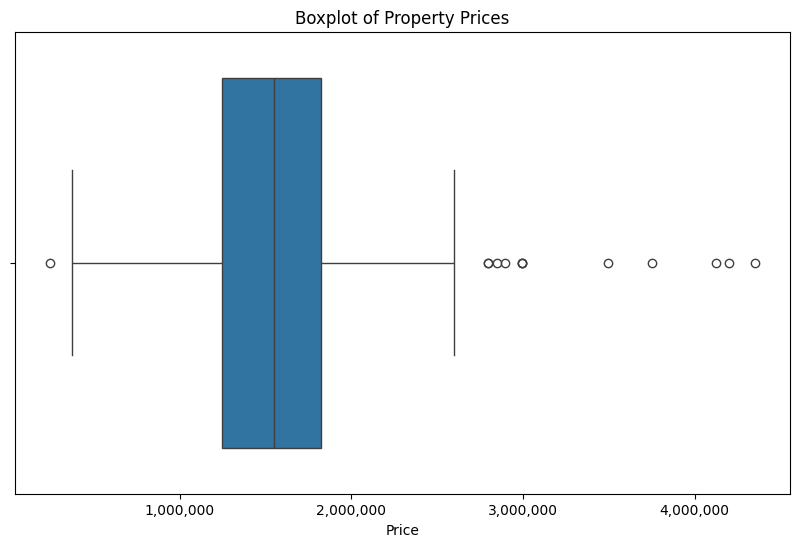

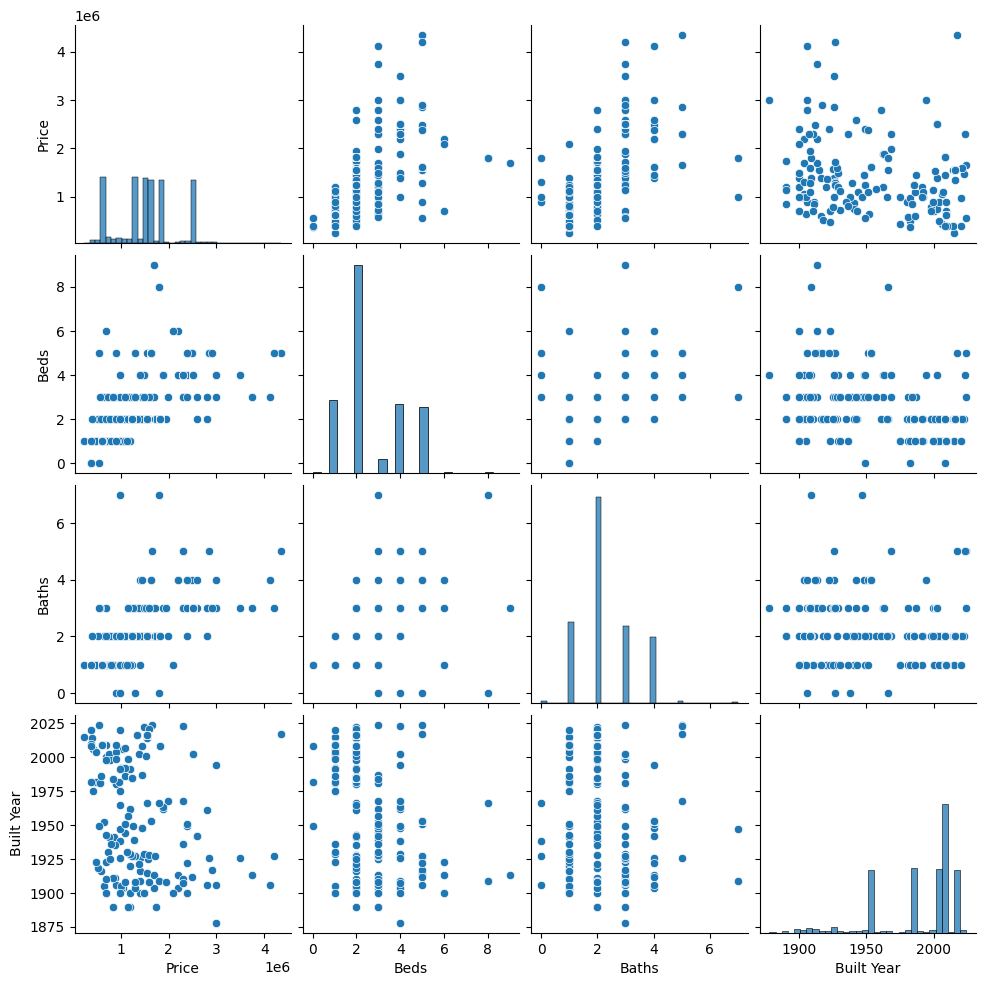

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Гистограммы для числовых признаков
plt.figure(figsize=(20, 15))
for i, column in enumerate(['Price', 'Beds', 'Baths', 'Built Year', 'Longitude', 'Latitude'], 1):
    plt.subplot(3, 2, i)
    data[column].plot(kind='hist', bins=50)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    if column == 'Price':
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

# Коробчатая  
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Price'])
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Boxplot of Property Prices')
plt.xlabel('Price')
plt.show()

sns.pairplot(data[['Price', 'Beds', 'Baths', 'Built Year']])
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(['Price'], axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Линейная регрессия как baseline модель
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Предсказание и оценка baseline модели
y_pred = baseline_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression MSE: {mse}")
print(f"Baseline Linear Regression R^2: {r2}")

Baseline Linear Regression MSE: 115488068881.42647
Baseline Linear Regression R^2: 0.6887508612666041


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(columns=['Price'])
y = data['Price']

# разделение данных 80% для обучения, 20% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели случайного леса с параметрами по умолчанию
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Вычисление метрик качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MSE: {mse}")
print(f"Random Forest R^2: {r2}")

Random Forest MSE: 56751612136.57241
Random Forest R^2: 0.8470500843045898


In [8]:
from sklearn.model_selection import GridSearchCV

# список гиперпараметров для GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV с 5-кратной перекрестной проверкой
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

# Предсказание и оценка новой оптимизированной модели
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Оценка метрик для оптимизированной модели
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Random Forest MSE: {mse_best}")
print(f"Optimized Random Forest R^2: {r2_best}")

Лучшие гиперпараметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest MSE: 42668033654.26349
Optimized Random Forest R^2: 0.8850064006181257


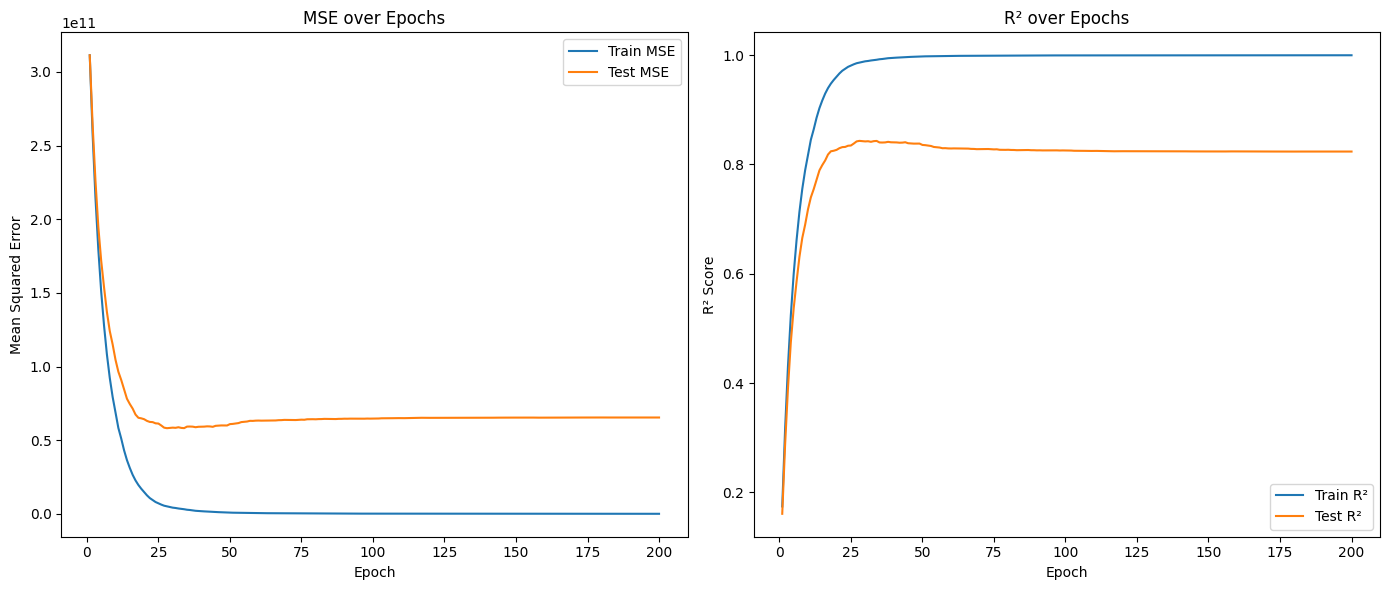

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Gradient Boosting с отслеживанием на каждом этапе
gb_model = GradientBoostingRegressor(
    n_estimators=200,     
    learning_rate=0.1,      
    max_depth=5,            
    random_state=42,
    warm_start=True       
)

train_mse, test_mse = [], []
train_r2, test_r2 = [], []

# Обучение модели и запись метрик после каждой эпохи
for i in range(1, gb_model.n_estimators + 1):
    gb_model.n_estimators = i
    gb_model.fit(X_train, y_train)
    
    # Предсказания для тренировочного набора
    y_train_pred = gb_model.predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    train_r2.append(r2_score(y_train, y_train_pred))
    
    # Предсказания для тестового набора
    y_test_pred = gb_model.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

plt.figure(figsize=(14, 6))

# MSE
plt.subplot(1, 2, 1)
plt.plot(range(1, gb_model.n_estimators + 1), train_mse, label='Train MSE')
plt.plot(range(1, gb_model.n_estimators + 1), test_mse, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE over Epochs')
plt.legend()

# R^2
plt.subplot(1, 2, 2)
plt.plot(range(1, gb_model.n_estimators + 1), train_r2, label='Train R²')
plt.plot(range(1, gb_model.n_estimators + 1), test_r2, label='Test R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

class GradientBoostingRegressorCustom:
    def __init__(self, estimators=100, rate=0.1, depth=3):
        self.estimators = estimators
        self.rate = rate
        self.depth = depth
        self.model_trees = []

    def fit(self, X, y):
        initial_value = np.mean(y)
        pred_values = np.full(y.shape, initial_value)
        self.base_prediction = initial_value

        for _ in range(self.estimators):
            residuals = y - pred_values

            model_tree = DecisionTreeRegressor(max_depth=self.depth)
            model_tree.fit(X, residuals)

            updates = self.rate * model_tree.predict(X)
            pred_values += updates

            self.model_trees.append(model_tree)
    
    def predict(self, X):
        pred_values = np.full((X.shape[0],), self.base_prediction)

        for model_tree in self.model_trees:
            pred_values += self.rate * model_tree.predict(X)
        
        return pred_values

custom_boosted_model = GradientBoostingRegressorCustom(estimators=100, rate=0.05, depth=2)
custom_boosted_model.fit(X_train, y_train)

y_train_pred = custom_boosted_model.predict(X_train)
y_test_pred = custom_boosted_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Custom Model with Regularization Performance")
print(f"Train MSE: {mse_train}")
print(f"Train R^2: {r2_train}")
print(f"Test MSE: {mse_test}")
print(f"Test R^2: {r2_test}")

Custom Model with Regularization Performance
Train MSE: 22655441580.431404
Train R^2: 0.9399210659196092
Test MSE: 42254861069.46973
Test R^2: 0.8861199321925202
